## Using Keras for Word Embedding as well as the LSTM

https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://keras.io/getting-started/functional-api-guide/

In [23]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.layers import Bidirectional, Dense, Dropout, Input, LSTM, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from os.path import join

In [24]:
FEATURES_DIR = join("..", "feature_extraction", "feature_outputs")
DATA_FILES_DIR = join("..", "feature_extraction", "data_files")
chat_logs_filename = join(DATA_FILES_DIR, "gnue_irc_chat_logs_preprocessed.txt")
summarized_chat_date_partitions_filename = join(
    DATA_FILES_DIR, "summarized_chat_date_partitions_cumulative_count.csv"
)
summarized_chat_log_ids_filename = join(DATA_FILES_DIR, "summarized_chat_log_ids.csv")
summarized_chat_features_filename = join(FEATURES_DIR, "summarized_chats_features.csv")

In [48]:
keep_rows = []
# def keep(rows): 
#     return x in rows
summarized_chat_date_partitions = pd.read_csv(
    summarized_chat_date_partitions_filename, skiprows=lambda x: x in keep_rows
)

In [49]:
summarized_chat_date_partitions

,min_log_id,date_of_log,chat_line_count,cumulative_count
0,85350,2001-11-05,2295,2295
1,92248,2001-11-02,163,2458
2,137598,2001-11-03,347,2805
3,144080,2001-11-04,846,3651
4,189748,2001-11-17,1259,4910
5,196981,2001-11-10,439,5349
6,216561,2001-11-11,448,5797
7,222782,2001-11-16,1132,6929
8,236439,2001-11-18,255,7184
9,270720,2001-10-29,481,7665


In [50]:
index_for_validation_test_split = summarized_chat_date_partitions.tail(4)["cumulative_count"]
index_for_validation_test_split = index_for_validation_test_split.values[0]
index_for_train_validation_split = summarized_chat_date_partitions.tail(8)["cumulative_count"]
index_for_train_validation_split = index_for_train_validation_split.values[0]
print(index_for_train_validation_split)
print(index_for_validation_test_split)

16079
20067


In [51]:
# read in data using pandas
unnormalized_summarized_chat_features_df = pd.read_csv(summarized_chat_features_filename)

In [52]:
unnormalized_summarized_chat_features_df.tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20710,624000,0.987539,2,0,0.0000,0.000432,0.003309,0.983457,0.281268,0
20711,624001,0.990654,4,0,0.0000,0.000801,0.006145,0.444846,0.127226,0
20712,624002,0.993769,7,0,0.5267,0.001122,0.008603,0.306102,0.087545,0
20713,624003,0.996885,0,0,0.4588,0.000000,0.000000,0.000000,0.000000,0
20714,624004,1.000000,1,0,0.0000,0.000803,0.006161,2.205475,0.630764,0


## Normalize the chat features data

We will use Standardization instead
52

Normalization rescales the values into a range of [0,1]. This might be useful in some cases where all parameters need to have the same positive scale. However, the outliers from the data set are lost.

𝑋𝑐ℎ𝑎𝑛𝑔𝑒𝑑=𝑋−𝑋𝑚𝑖𝑛𝑋𝑚𝑎𝑥−𝑋𝑚𝑖𝑛

Standardization rescales data to have a mean (𝜇) of 0 and standard deviation (𝜎) of 1 (unit variance).

𝑋𝑐ℎ𝑎𝑛𝑔𝑒𝑑=𝑋−𝜇𝜎

For most applications standardization is recommended.
https://stats.stackexchange.com/questions/10289/whats-the-difference-between-normalization-and-standardization

In [53]:
chat_data_max_values = unnormalized_summarized_chat_features_df.max()
chat_data_min_values = unnormalized_summarized_chat_features_df.min()

max_number_of_special_terms = chat_data_max_values.number_of_special_terms
max_sentence_length = chat_data_max_values.sentence_length
max_sentiment_score = chat_data_max_values.sentiment_score
max_absolute_sentence_position = chat_data_max_values.absolute_sentence_position
max_mean_tf_idf = chat_data_max_values.mean_tf_idf
max_mean_tf_isf = chat_data_max_values.mean_tf_isf
max_normalized_mean_tf_idf = chat_data_max_values.normalized_mean_tf_idf
max_normalized_mean_tf_isf = chat_data_max_values.normalized_mean_tf_isf

min_number_of_special_terms = chat_data_min_values.number_of_special_terms
min_sentence_length = chat_data_min_values.sentence_length
min_sentiment_score = chat_data_min_values.sentiment_score
min_absolute_sentence_position = chat_data_min_values.absolute_sentence_position
min_mean_tf_idf = chat_data_min_values.mean_tf_idf
min_mean_tf_isf = chat_data_min_values.mean_tf_isf
min_normalized_mean_tf_idf = chat_data_min_values.normalized_mean_tf_idf
min_normalized_mean_tf_isf = chat_data_min_values.normalized_mean_tf_isf

print(min_sentiment_score)
print(max_sentiment_score)
print(min_absolute_sentence_position)
print(max_absolute_sentence_position)
print(min_mean_tf_idf)
print(min_mean_tf_isf)
print(min_normalized_mean_tf_idf)
print(min_normalized_mean_tf_isf)
print(max_mean_tf_idf)
print(max_mean_tf_isf)
print(max_normalized_mean_tf_idf)
print(max_normalized_mean_tf_isf)
max_sentence_length
chat_data_max_values["normalized_mean_tf_idf"]

-0.9529
0.9707
0.00043572984749455336
1.0
0.0
0.0
0.0
0.0
0.04073392898973263
3.36078268987328
0.3123448778466237
0.9611808193277522


0.3123448778466237

In [92]:
chat_log_df = unnormalized_summarized_chat_features_df.copy()
chat_log_df.sentence_length = (
    chat_log_df.sentence_length - min_sentence_length) / (
    max_sentence_length - min_sentence_length)
chat_log_df.number_of_special_terms = (
    chat_log_df.number_of_special_terms - min_number_of_special_terms) / (
    max_number_of_special_terms - min_number_of_special_terms)
print(chat_log_df.sentence_length.head())
chat_log_df.iloc[-5:]

0    0.013699
1    0.178082
2    0.136986
3    0.068493
4    0.109589
Name: sentence_length, dtype: float64


,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20710,624000,0.987539,0.027397,0.0,0.0000,0.000432,0.003309,0.983457,0.281268,0
20711,624001,0.990654,0.054795,0.0,0.0000,0.000801,0.006145,0.444846,0.127226,0
20712,624002,0.993769,0.095890,0.0,0.5267,0.001122,0.008603,0.306102,0.087545,0
20713,624003,0.996885,0.000000,0.0,0.4588,0.000000,0.000000,0.000000,0.000000,0
20714,624004,1.000000,0.013699,0.0,0.0000,0.000803,0.006161,2.205475,0.630764,0


In [93]:
def normalize_data_set(data_set_df, features_to_normalize=()):
    """
    Normalize data in the data set
    :param data_set_df: A pandas data frame containing the data to be normalized
    :param features_to_normalize: The names of the features / columns to normalize in the data frame
    :return: new data frame with normalized_values
    """
    data_max_values = data_set_df.max()
    data_min_values = data_set_df.min()

    if not features_to_normalize:
        features_to_normalize = [
            "number_of_special_terms",
            "sentence_length",
            "sentiment_score",
            "absolute_sentence_position",
            "mean_tf_idf",
            "mean_tf_isf",
            "normalized_mean_tf_idf",
            "normalized_mean_tf_isf",
        ]

    new_data_set_df = data_set_df.copy()

    for feature in features_to_normalize:
        new_data_set_df[feature] = (
            new_data_set_df[feature] - data_min_values[feature]) / (
            data_max_values[feature] - data_min_values[feature]
        )

    return new_data_set_df


In [94]:
normalize_data_set(unnormalized_summarized_chat_features_df).tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20710,624000,0.987534,0.027397,0.0,0.495373,0.010594,0.010594,0.292627,0.292627,0
20711,624001,0.990650,0.054795,0.0,0.495373,0.019673,0.019673,0.132364,0.132364,0
20712,624002,0.993767,0.095890,0.0,0.769183,0.027545,0.027545,0.091081,0.091081,0
20713,624003,0.996883,0.000000,0.0,0.733884,0.000000,0.000000,0.000000,0.000000,0
20714,624004,1.000000,0.013699,0.0,0.495373,0.019725,0.019725,0.656239,0.656239,0


In [96]:
# Remove unneeded columns. Keep only normalized columns
columns_to_drop = ["log_id", "is_summary", "mean_tf_idf", "mean_tf_isf"]
chat_log_df = chat_log_df.drop(columns=columns_to_drop)
chat_log_df.tail()

,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
20710,0.987539,0.027397,0.0,0.0000,0.003309,0.281268
20711,0.990654,0.054795,0.0,0.0000,0.006145,0.127226
20712,0.993769,0.095890,0.0,0.5267,0.008603,0.087545
20713,0.996885,0.000000,0.0,0.4588,0.000000,0.000000
20714,1.000000,0.013699,0.0,0.0000,0.006161,0.630764


In [115]:
train_features_X = chat_log_df.iloc[:index_for_train_validation_split]
validation_features_X = chat_log_df.iloc[index_for_train_validation_split:index_for_validation_test_split]
test_features_X = chat_log_df.iloc[index_for_validation_test_split:]
train_features_X.tail()

assert train_features_X.shape[1] == test_features_X.shape[1] 
assert test_features_X.shape[1] == validation_features_X.shape[1] 
print(test_features_X.shape)
test_features_X.head()

pd.DataFrame([1,2,3,4])
c = unnormalized_summarized_chat_features_df
d = [[34, 3], [2, 0], [1, 4], [7, 3]]
ddf = pd.DataFrame(d)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(ddf))
print(scaler.mean_)
st = pd.DataFrame(scaler.transform(ddf), columns=ddf.columns.values)
print(scaler.mean_)
ddf.columns.values
st

(648, 6)
StandardScaler(copy=True, with_mean=True, with_std=True)
[11.   2.5]
[11.   2.5]


/Users/wcyn/anaconda3/envs/gnue-irc/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/wcyn/anaconda3/envs/gnue-irc/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


,0,1
0,1.707220,0.333333
1,-0.668043,-1.666667
2,-0.742270,1.000000
3,-0.296908,0.333333


In [59]:
summarized_chat_log_ids = pd.read_csv(
    summarized_chat_log_ids_filename,
    names=["log_id", "is_summary"]
)

In [60]:
summarized_chat_log_ids.head()

,log_id,is_summary
0,85350,0
1,85351,0
2,85352,0
3,85353,0
4,85354,0


In [61]:
def get_summarized_chat_logs(chat_logs_filename, summarized_chat_log_ids):
    summarized_chat_log_ids = set(summarized_chat_log_ids)
    chats = []
    with open(chat_logs_filename) as chat_logs:
        line_number = 1
        for chat_log in chat_logs:
            if line_number in summarized_chat_log_ids:
                chats.append(chat_log)
            line_number += 1
    return chats

In [62]:
chat_logs = get_summarized_chat_logs(chat_logs_filename, summarized_chat_log_ids.log_id.values)
chat_logs[:5]

['great\n',
 'i dont recall you ever telling me what you do at your job\n',
 "and you probably can't be persuaded to tell me now.\n",
 'due to your persistant funkitude\n',
 'umm, he sits around on irc all day ;)\n']

In [63]:
# Create a Tokenizer Object
tokenizer = Tokenizer(
    num_words=None,
    filters="\n",
    lower = False, 
    split = ' '
)
tokenizer.fit_on_texts(chat_logs)

In [64]:
sequences = tokenizer.texts_to_sequences(chat_logs)

In [65]:
sequences[4]

[3099, 72, 4137, 300, 16, 584, 34, 309, 54]

In [66]:
word_indexes = tokenizer.index_word
def get_words_at_line_number(word_indexes, line_number):
    return " ".join(word_indexes[word] for word in sequences[line_number])

In [67]:
get_words_at_line_number(word_indexes, 2)

"and you probably can't be persuaded to tell me now."

In [68]:
tokenizer.index_word[356]

'language'

In [69]:
train_X = np.array(sequences[:index_for_train_validation_split])
validation_X = np.array(sequences[index_for_train_validation_split:index_for_validation_test_split])
test_X = np.array(sequences[index_for_validation_test_split:])
print(train_X.shape)
print(test_X.shape)
print(train_X[:1])
print(len(test_X))
test_X[-5:]

(16079,)
(648,)
[list([547])]
648


array([list([107, 18365]), list([128, 9, 31, 1456]),
       list([18366, 342, 36, 3591, 515, 29, 18367, 14]), list([14]),
       list([1454])], dtype=object)

In [87]:
# create a one hot encoding for the target column
chat_log_labels = to_categorical(summarized_chat_log_ids.is_summary)

train_y = chat_log_labels[:index_for_train_validation_split]
validation_y = chat_log_labels[index_for_train_validation_split:index_for_validation_test_split]
test_y = chat_log_labels[index_for_validation_test_split:]

s = pd.DataFrame([0, 1, 0, 0 ,0 ,0, 1,1,0])
type(s)
to_categorical(s)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [90]:
test_y[80:100]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [91]:
# pad input sequences
max_chat_length = max(len(seq) for seq in sequences)
train_X = sequence.pad_sequences(train_X, maxlen=max_chat_length)
validation_X = sequence.pad_sequences(validation_X, maxlen=max_chat_length)
test_X = sequence.pad_sequences(test_X, maxlen=max_chat_length)

In [92]:
print(train_X.shape)
print(test_X.shape)
print(validation_X.shape)
print(validation_X[0])

(16079, 73)
(648, 73)
(3988, 73)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     4  1575    20   103    15     3 15875   908    12   125  1051
    14]


In [126]:
# create the model
top_words = 100000
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_chat_length))
model.add(Bidirectional(LSTM(100), input_shape=(max_chat_length, 1)))
# model.add((LSTM(100)))
# model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.add(Dense(2, activation='sigmoid'))



In [127]:
# This returns a tensor
# inputs = Input(shape=(784,))
# # a layer instance is callable on a tensor, and returns a tensor
# x = Dense(64, activation='relu')(inputs)
# x = Dense(64, activation='relu')(x)
# predictions = Dense(10, activation='softmax')(x)

# # This creates a model that includes
# # the Input layer and three Dense layers
# model = Model(inputs=inputs, outputs=predictions)
# model.compile(optimizer='rmsprop',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(data, labels)  # starts training

In [142]:
# Sentence input: meant to receive sequences of `max_chat_length` integers, between 1 and `top_words`.
main_sentence_input = Input(shape=(max_chat_length,), dtype='int32', name='main_sentence_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=512, input_dim=top_words, input_length=max_chat_length)(main_sentence_input)

# An LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

In [143]:
# Here we insert the auxiliary loss, allowing the LSTM and Embedding layer 
# to be trained smoothly even though the main loss will be much higher in the model.
auxiliary_output = Dense(2, activation='sigmoid', name='aux_output')(lstm_out)

# At this point, we feed into the model our auxiliary input data by 
# concatenating it with the LSTM output
num_of_feature_columns = test_features_X.shape[1]
sentence_features_input = Input(shape=(num_of_feature_columns,), name='sentence_features_input')
merged_input_and_output = keras.layers.concatenate([lstm_out, sentence_features_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(merged_input_and_output)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(2, activation='sigmoid', name='main_output')(x)

In [144]:
# Define a model with two inputs and two outputs
merged_model = Model(
    inputs=[main_sentence_input, sentence_features_input], 
    outputs=[main_output, auxiliary_output]
)

We compile the model and assign a weight of 0.2 to the auxiliary loss. To specify different loss_weights or loss for each different output, you can use a list or a dictionary. Here we pass a single loss as the loss argument, so the same loss will be used on all outputs.

In [146]:
merged_model.compile(
    optimizer='rmsprop', 
    #optimizer="adam",
    loss='categorical_crossentropy',
    loss_weights=[1., 0.2]
)
merged_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_sentence_input (InputLayer (None, 73)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 73, 512)      51200000    main_sentence_input[0][0]        
__________________________________________________________________________________________________
lstm_14 (LSTM)                  (None, 32)           69760       embedding_10[0][0]               
__________________________________________________________________________________________________
sentence_features_input (InputL (None, 6)            0                                            
__________________________________________________________________________________________________
concatenat

In [149]:
# Train the model by passing it lists of input arrays and target arrays 19960.996418952942  seconds
# 25183.798012971878  seconds Second time, with 30 minute break in between
start = time.time()
merged_model_history = merged_model.fit(
    [train_X, train_features_X], 
    [train_y, train_y],
    #validation_split=0.2,
    validation_data=[
        [validation_X, validation_features_X], 
        [validation_y, validation_y]
    ],
    epochs=100, 
    batch_size=64
)
end = time.time()
print(end - start, " seconds")

Train on 16079 samples, validate on 3988 samples
Epoch 1/100
16079/16079 [==============================] - 536s 33ms/step - loss: 0.1506 - main_output_loss: 0.1255 - aux_output_loss: 0.1252 - val_loss: 0.1633 - val_main_output_loss: 0.1375 - val_aux_output_loss: 0.1287
Epoch 2/100
16079/16079 [==============================] - 164s 10ms/step - loss: 0.1430 - main_output_loss: 0.1192 - aux_output_loss: 0.1189 - val_loss: 0.1582 - val_main_output_loss: 0.1318 - val_aux_output_loss: 0.1319
Epoch 3/100
16079/16079 [==============================] - 169s 11ms/step - loss: 0.1283 - main_output_loss: 0.1067 - aux_output_loss: 0.1083 - val_loss: 0.1743 - val_main_output_loss: 0.1464 - val_aux_output_loss: 0.1393
Epoch 4/100
16079/16079 [==============================] - 170s 11ms/step - loss: 0.0996 - main_output_loss: 0.0812 - aux_output_loss: 0.0917 - val_loss: 0.2221 - val_main_output_loss: 0.1901 - val_aux_output_loss: 0.1601
Epoch 5/100
16079/16079 [==============================] - 171s

Epoch 74/100
16079/16079 [==============================] - 170s 11ms/step - loss: 0.0069 - main_output_loss: 0.0058 - aux_output_loss: 0.0056 - val_loss: 2.0155 - val_main_output_loss: 1.7773 - val_aux_output_loss: 1.1912
Epoch 75/100
16079/16079 [==============================] - 171s 11ms/step - loss: 0.0096 - main_output_loss: 0.0082 - aux_output_loss: 0.0070 - val_loss: 2.3168 - val_main_output_loss: 2.0729 - val_aux_output_loss: 1.2192
Epoch 76/100
16079/16079 [==============================] - 172s 11ms/step - loss: 0.0083 - main_output_loss: 0.0072 - aux_output_loss: 0.0054 - val_loss: 2.6030 - val_main_output_loss: 2.3298 - val_aux_output_loss: 1.3658
Epoch 77/100
16079/16079 [==============================] - 172s 11ms/step - loss: 0.0072 - main_output_loss: 0.0060 - aux_output_loss: 0.0057 - val_loss: 1.8970 - val_main_output_loss: 1.6763 - val_aux_output_loss: 1.1037
Epoch 78/100
16079/16079 [==============================] - 169s 11ms/step - loss: 0.0086 - main_output_loss

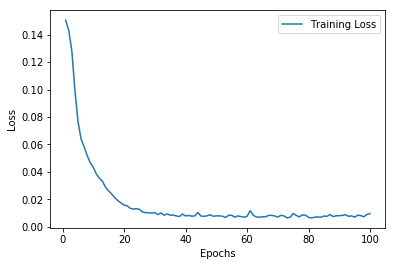

In [150]:
merged_model_loss_values = merged_model_history.history['loss']
merged_model_epochs = range(1, len(merged_model_loss_values)+1)

plt.plot(merged_model_epochs, merged_model_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [163]:
merged_model_filename = join(DATA_FILES_DIR, 'merged_hybrid_model.h5')
merged_model.save(merged_model_filename)

In [164]:
loaded_merged_model = load_model(merged_model_filename)

In [128]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 73, 32)            3200000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 402       
Total params: 3,306,802
Trainable params: 3,306,802
Non-trainable params: 0
_________________________________________________________________


In [129]:
# 3036.66828584671
start = time.time()
history = model.fit(
    train_X, 
    train_y, 
    validation_data=(validation_X, validation_y), 
    epochs=100, 
    batch_size=2048
)
end = time.time()
print(end-start, " seconds")

Train on 16079 samples, validate on 3988 samples
Epoch 1/100
16079/16079 [==============================] - 22s 1ms/step - loss: 0.6377 - acc: 0.9469 - val_loss: 0.5210 - val_acc: 0.9709
Epoch 2/100
16079/16079 [==============================] - 18s 1ms/step - loss: 0.2847 - acc: 0.9684 - val_loss: 0.1497 - val_acc: 0.9709
Epoch 3/100
16079/16079 [==============================] - 19s 1ms/step - loss: 0.1524 - acc: 0.9684 - val_loss: 0.1314 - val_acc: 0.9709
Epoch 4/100
16079/16079 [==============================] - 18s 1ms/step - loss: 0.1427 - acc: 0.9684 - val_loss: 0.1348 - val_acc: 0.9709
Epoch 5/100
16079/16079 [==============================] - 18s 1ms/step - loss: 0.1405 - acc: 0.9684 - val_loss: 0.1320 - val_acc: 0.9709
Epoch 6/100
16079/16079 [==============================] - 19s 1ms/step - loss: 0.1409 - acc: 0.9684 - val_loss: 0.1314 - val_acc: 0.9709
Epoch 7/100
16079/16079 [==============================] - 21s 1ms/step - loss: 0.1396 - acc: 0.9684 - val_loss: 0.1319 - v

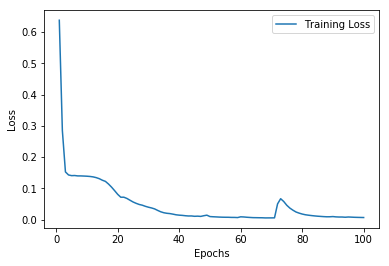

In [130]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [151]:
test_y_predictions = loaded_merged_model.predict([test_X, test_features_X])
validation_y_predictions = loaded_merged_model.predict([validation_X, validation_features_X])

test_y_argmax = np.argmax(test_y,axis=1)
validation_y_argmax = np.argmax(validation_y,axis=1)

test_y_predictions_argmax = np.argmax(test_y_predictions[1], axis=1)
validation_y_predictions_argmax = np.argmax(validation_y_predictions[1], axis=1)

In [131]:
test_y_predictions = model.predict(test_X)
validation_y_predictions = model.predict(validation_X)

test_y_argmax = np.argmax(test_y,axis=1)
validation_y_argmax = np.argmax(validation_y,axis=1)

test_y_predictions_argmax = np.argmax(test_y_predictions, axis=1)
validation_y_predictions_argmax = np.argmax(validation_y_predictions, axis=1)

In [152]:
test_y_predictions[:10]

[array([[1.3113022e-06, 9.9559379e-01],
        [2.9699147e-02, 5.9604645e-08],
        [1.4858201e-01, 8.9406967e-08],
        ...,
        [0.0000000e+00, 9.9992126e-01],
        [1.3409239e-01, 2.9802322e-07],
        [2.3387089e-01, 6.2286854e-06]], dtype=float32),
 array([[9.5286965e-04, 3.1424105e-02],
        [9.0528780e-01, 4.0978193e-05],
        [7.7358443e-01, 2.4735928e-06],
        ...,
        [6.9218874e-04, 3.8036972e-02],
        [5.5010247e-01, 3.0606985e-05],
        [6.7977536e-01, 1.2323260e-04]], dtype=float32)]

In [153]:
test_y_predictions_argmax[:100]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [154]:
test_y_argmax[:100]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [156]:
print(classification_report(test_y_argmax, test_y_predictions_argmax))
print(confusion_matrix(test_y_argmax, test_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85       619
           1       0.05      0.28      0.09        29

   micro avg       0.74      0.74      0.74       648
   macro avg       0.50      0.52      0.47       648
weighted avg       0.92      0.74      0.81       648

[[471 148]
 [ 21   8]]


In [165]:
from rouge_metrics import *
from get_sentences_from_line_numbers import *

predicted_line_numbers = [index_for_validation_test_split + index + 1 for index, value in enumerate(test_y_predictions_argmax) if value==1]
summaries_line_numbers = [index_for_validation_test_split + index + 1 for index, value in enumerate(test_y_argmax) if value==1]

summaries_chat_lines = get_sentences_of_line_numbers(CHAT_LOGS, summaries_line_numbers)
predicted_chat_lines = get_sentences_of_line_numbers(CHAT_LOGS, predicted_line_numbers)
print("SUMMARIES\n---------\n", summaries_chat_lines)
print("PREDICTIONS\n-----------\n", predicted_chat_lines)

hypotheses = [predicted_chat_lines]
references = [summaries_chat_lines]
print("ROUGE Scores\n------------")
print_rouge_results(get_rouge_results(hypotheses, references))

SUMMARIES
---------
 btw, why are ou guys calling this abstraction thingy GComm when Dave has a project called GNU Comm (GComm fr short)?
as far as I'm concerned, GComm is our internal package name... to the external world, it's GNUe Common
but that is a good point
pyro is an object system like what gcomm will be
by same guys that wrote pygmy
the python email client
I need a production quality GNUe web shopping cart ;-)
anything is possible I know, but ideally we need to get ideas on some sort of php and GEAS interface
guess I'll just customize interchange.. hopefully actually have it done in a few days
our inventory package isn't completed
but if you have an inventory package
you should be able to access it via geas
I know a web interface for GNUe Forms is in the works, but I'm sure you need something relatively quickly
madlocke was working on that, but as you probably know, he's been out of commission (sick) lately
a new release (feature wise) is probably about 3 or 4 weeks away sinc

In [108]:
print(classification_report(validation_y_argmax, validation_y_predictions_argmax))
print(confusion_matrix(validation_y_argmax, validation_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3872
           1       0.05      0.04      0.04       116

   micro avg       0.95      0.95      0.95      3988
   macro avg       0.51      0.51      0.51      3988
weighted avg       0.94      0.95      0.95      3988

[[3769  103]
 [ 111    5]]


In [208]:
y_actual_and_prediction = list(zip(test_y_argmax, test_y_predictions_argmax))
[y for i, y in enumerate(y_actual_and_prediction)][80:100]

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (0, 1)]

In [225]:
log_ids_for_false_positives = []
log_ids_for_false_negatives = []
log_ids_for_true_positives = []
offset = index_for_validation_test_split
for index, value in enumerate(y_actual_and_prediction):
    if value == (0, 1):
        log_ids_for_false_positives.append(offset + index)
    elif value == (1, 0):
        log_ids_for_false_negatives.append(offset + index)
    elif value == (1,1):
        log_ids_for_true_positives.append(offset + index)
    
log_ids_for_false_positives = [index_for_validation_test_split + index for index, value in enumerate(y_actual_and_prediction) if value==(0, 1)]
log_ids_for_false_positives = [index_for_validation_test_split + index for index, value in enumerate(y_actual_and_prediction) if value==(0, 1)]
print(len(log_ids_for_false_positives))
print(len(log_ids_for_false_negatives))
print(len(log_ids_for_true_positives))
log_ids_for_false_positives[:10]

32
25
4


[20085, 20105, 20106, 20109, 20136, 20138, 20166, 20202, 20211, 20248]

In [224]:
for log_id in log_ids_for_false_positives:
    print(get_words_at_line_number(word_indexes, log_id))

or, for simplicity, print md5.new(string).digest() :)
BUT from geas/DBdriver.py:
def _make_passkey(self, user, passwd, random):
def _hexstr(self, s):
but when I update or co, it comes back
doesn't jamest have access to the cvs server?
either that or I customize interchange
(basically Python-based web application services
webware and GNUe might be interesting
real or imagined
any suggestions/comments?
doesn't it still have a usenet gateway?
and windows isnt a 'monitorless' operating system
there is an option to open as access as 97
i will get 97 up here pretty quick
and be much more 'official' than informal help
more official?
i.e. accountable
any non ie 5.0 or greater browser in fact
F*** YOU! No MSN for you.
this is really really incredible
I always wondered if gnuebot and bigbrother secretly fought in the background
either with win2k or kde&linux
the major hangup is of course.....drumroll....Office
what's it running per seat?
I strongly dislike cygwin's setup
if exists (select 1 from

In [226]:
for log_id in log_ids_for_true_positives:
    print(get_words_at_line_number(word_indexes, log_id))

pyro is an object system like what gcomm will be
the python email client
you should be able to access it via geas
and todo tool


In [227]:
for log_id in log_ids_for_false_negatives:
    print(get_words_at_line_number(word_indexes, log_id))

btw, why are ou guys calling this abstraction thingy GComm when Dave has a project called GNU Comm (GComm fr short)?
as far as I'm concerned, GComm is our internal package name... to the external world, it's GNUe Common
but that is a good point
by same guys that wrote pygmy
I need a production quality GNUe web shopping cart ;-)
anything is possible I know, but ideally we need to get ideas on some sort of php and GEAS interface
guess I'll just customize interchange.. hopefully actually have it done in a few days
our inventory package isn't completed
but if you have an inventory package
I know a web interface for GNUe Forms is in the works, but I'm sure you need something relatively quickly
madlocke was working on that, but as you probably know, he's been out of commission (sick) lately
a new release (feature wise) is probably about 3 or 4 weeks away since the db upgrade is going to be huge
I may make an interim bug fix/small feature release to get some of the email support down
but we a

#### Merged Model predictions

In [390]:
merged_test_y_predictions = merged_model.predict([test_X, test_features_X])
merged_validation_y_predictions = merged_model.predict([validation_X, validation_features_X])

merged_test_y_argmax = np.argmax(test_y,axis=1)
merged_validation_y_argmax = np.argmax(validation_y,axis=1)

merged_test_y_predictions_argmax = np.argmax(merged_test_y_predictions[1], axis=1)
merged_validation_y_predictions_argmax = np.argmax(merged_validation_y_predictions[1], axis=1)

In [8]:
print(merged_test_y_predictions_argmax[:100])
# print(merged_test_y_predictions[0])
print(merged_test_y_argmax[:100])

NameError: name 'merged_test_y_predictions_argmax' is not defined

In [392]:
print(classification_report(merged_test_y_argmax, merged_test_y_predictions_argmax))
print(confusion_matrix(merged_test_y_argmax, merged_test_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       619
           1       0.12      0.17      0.14        29

   micro avg       0.91      0.91      0.91       648
   macro avg       0.54      0.56      0.55       648
weighted avg       0.92      0.91      0.92       648

[[584  35]
 [ 24   5]]


In [393]:
print(classification_report(merged_validation_y_argmax, merged_validation_y_predictions_argmax))
print(confusion_matrix(merged_validation_y_argmax, merged_validation_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3872
           1       0.04      0.08      0.05       116

   micro avg       0.92      0.92      0.92      3988
   macro avg       0.50      0.51      0.50      3988
weighted avg       0.94      0.92      0.93      3988

[[3642  230]
 [ 107    9]]
